In [18]:
#imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import functools
import time

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

#enable eager execution
#tf.enable_eager_execution()

In [19]:
#setting dirs
img_dir = '/content/drive/MyDrive/cdvbw22/pics'
pat_dir = '/content/drive/MyDrive/cdvbw22/patterns'
transfer_dir = '/content/drive/MyDrive/cdvbw22/results'

#setting width/height for images in processing
hight = 512
width = 512

# Content layers of VGG16 where feature maps are pulled for content
# lass use of structure cmpared to conv4/5_2
content_layers = ['block2_conv2'] 

# VGG19 layers we use to extract style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]
#get nums of layers for calculation
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [20]:
#img_utils

#load image and scale to max 512 px
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  #resize images
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  #img = kp_image.img_to_array(img)
  
  # broadcast the image array without batch dimension 
  img = np.expand_dims(img, axis=0)
  return img


def img_show(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

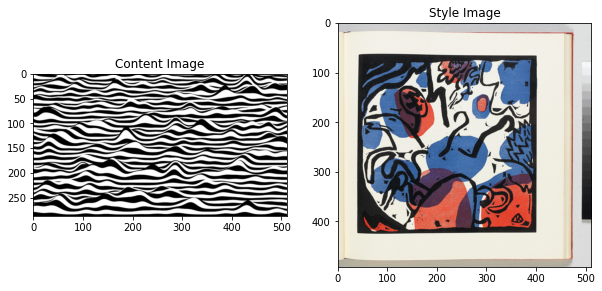

In [52]:
style_path = '/content/drive/MyDrive/cdvbw22/pics/sgs_grs_kandinsky_1970-16636-16_001_s.jpg'
content_path = '/content/drive/MyDrive/cdvbw22/patterns/b&white_waves.webp'

#get input
content_img = load_img(content_path).astype('uint8')
style_img = load_img(style_path).astype('uint8')

#display images
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
img_show(content_img, 'Content Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style Image')
plt.show()

-------

In [22]:
#utils datapreparation

def load_and_process_img(path):
  #load dimage
  img = load_img(path)
  #use integrated preprocessing of kerad for vgg
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

# reverse to view outputs of optimization keeping values within normalized reach
def deprocess_img(img):
  #get copy of image
  x = img.copy()
  #get dimensions as (row (height), column (width), color (3))
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3,("Input img of wrong dimensions")
  #check if dimensions have been set to 3
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step, reverse substraction
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  #x = x[:, :, ::-1]

  #maintain values between 0 and 255, optimized picture can have different values
  x = np.clip(x, 0, 255).astype('uint8')
  return x

_______

In [23]:
#model creation
# ft to create model and intermediate layers
# loads VGG16 to acess intermediate layers to create new model
# return: keras model that takes img input and outputs intermediate layers (style and content)

# Load our model. We load pretrained VGG, trained on imagenet data
# vgg16 should be enough, gaining a little bit of speed compared to VGG19
def get_model():
  #fetch model without top
  vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to specified style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

______

In [24]:
#loss as distance metric

#content loss
def calc_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))


#style loss with gram matrices
def gram_matrix(input_tensor):
  # create img channles
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def calc_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # loss at a given layer is scaled by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  #get gram matrix
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [25]:
#gradient descent

def get_representations(model, content_path, style_path):
  #load images
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  #bacth compute features
  style_outputs = model(style_image)
  content_outputs = model(content_image)

  #get features from model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [37]:
#compute loss

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """Inputs: 
  model: created model for acess to intermedite layers
  loss_weights: weights of each contribution of each loss funciton
  init_img: init base images, gradients with loss are applied to this img
  gram_style_features: precomputed gram matrices of layers
  content_features: precomputed outputs of lyers

  Return:
  total loss, style loss, content loss and total variational loss
  """
  #set weights to input
  style_weight, content_weight = loss_weights
  model_outputs = model(init_image)
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  #init scores
  style_score = 0
  content_score = 0

  #Accumulate style losses from all layers
  # qually weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  #zip to create iterator containing gram features and output features
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * calc_style_loss(comb_style[0], target_style)

  #accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* calc_content_loss(comb_content[0], target_content)

  #calc score * weight
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss and return
  loss = style_score + content_score 
  return loss, style_score, content_score

def compute_gradients(config):
  #calculate loss with tf
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**config)
  total_loss = all_loss[0]
  return tape.gradient(total_loss, config['init_image']), all_loss

_______

In [67]:
def style_transfer(content_path, style_path, num_iterations=600, content_weight=1e3, style_weight=1e-2): 
  model = get_model()
  #set as non trainable
  for layer in model.layers:
    layer.trainable = False

  #get intermediate layers & gram layer for style and content
  style_features, content_features = get_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1,)

  # Store our best result
  best_loss, best_img = float('inf'), None

  #create config for gradient computation
  loss_weights = (style_weight, content_weight)
  config = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_gradients(config)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())
    
    plot_img = init_image.numpy()
    plot_img = deprocess_img(plot_img)
    imgs.append(plot_img)

  #get input
  content_img = load_img(content_path).astype('uint8')
  style_img = load_img(style_path).astype('uint8')

  #display images
  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  img_show(content_img, 'Content Image')

  plt.subplot(1, 2, 2)
  img_show(style_img, 'Style Image')

  plt.figure(figsize=(18,5))
  num_rows = 2
  num_cols = 6
  for i,img in enumerate(imgs):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
  

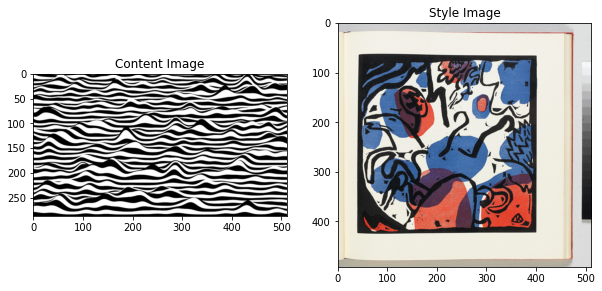

In [50]:
style_path = '/content/drive/MyDrive/cdvbw22/pics/sgs_grs_kandinsky_1970-16636-16_001_s.jpg'
content_path = '/content/drive/MyDrive/cdvbw22/patterns/b&white_waves.webp'

#get input
content_img = load_img(content_path).astype('uint8')
style_img = load_img(style_path).astype('uint8')

#display images
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
img_show(content_img, 'Content Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style Image')
plt.show()

In [82]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1,)


  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_gradients(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

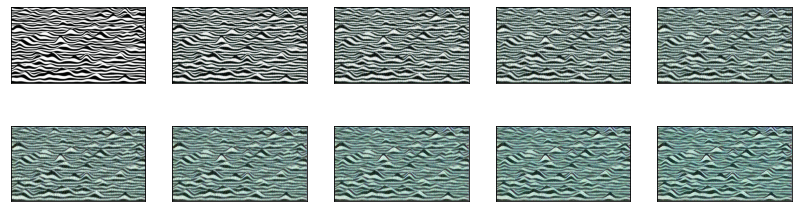

In [85]:
#connect GDrive
#from google.colab import drive
#drive.mount('/content/drive')

#apply transfer
#style_path = '/content/drive/MyDrive/cdvbw22/pics/sgs_grs_graeb_c-2017-5756-72_001_s.jpg'
#content_path = '/content/drive/MyDrive/cdvbw22/patterns/b&white_waves.webp'

best, best_loss = run_style_transfer(content_path, style_path, num_iterations=60)
plt.savefig('/content/drive/MyDrive/cdvbw22/results/kadinsky.png')


In [80]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  img_show(content, 'Content Image')

  plt.subplot(1, 2, 2)
  img_show(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [ ]:
show_results(best, content_path, style_path)

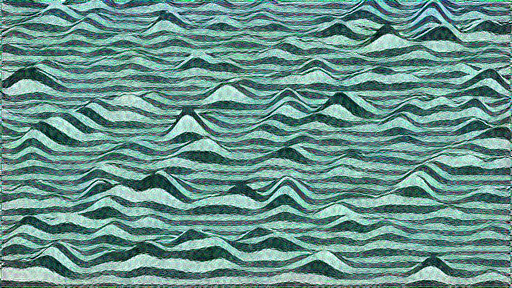

Iteration: 70
Total loss: 6.6720e+08, style loss: 1.0224e+08, content loss: 5.6496e+08, time: 0.0427s


In [ ]:
#iterative for lists of content

results_dir = '/content/drive/MyDrive/cdvbw22/results/'

filename_list = ['sgs_grs_graeb_c-2017-5756-72_001_s.jpg', 'sgs_grs_graeb_c-2017-5756-72_001_s.jpg', 'piglhein_1224.jpg' ]
style_list = ['/content/drive/MyDrive/cdvbw22/pics/sgs_grs_graeb_c-2017-5756-72_001_s.jpg', '/content/drive/MyDrive/cdvbw22/pics/sgs_grs_kandinsky_1970-16636-16_001_s.jpg', '/content/drive/MyDrive/cdvbw22/pics/piglhein_1224.jpg', '/content/drive/MyDrive/cdvbw22/pics/sgs_grs_graeb_c-2017-5756-72_001_s.jpg']
content_path = '/content/drive/MyDrive/cdvbw22/patterns/b&white_waves.webp'

for elem, name in zip(style_list, filename_list):
  run_style_transfer(content_path, elem, num_iterations=700)
  plt.savefig(results_dir + name)
  show_results(best, content_path, elem)
  plt.savefig(results_dir + "input" + name)